In [1]:
from itertools import combinations

import matplotlib.pyplot as plt
import pandas as pd
import scipy
import seaborn as sns
from scikit_posthocs import posthoc_dunn, posthoc_conover
import numpy as np
from scipy.stats import anderson, kruskal, mannwhitneyu, shapiro, spearmanr

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
sns.set()

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
df = pd.read_pickle("all_tweets_v15.pkl")
df = df[df.tweet_type == "standard"]
df.head(3)

,author_id,context_annotations,conversation_id,created_at,edit_history_tweet_ids,id,in_reply_to_user_id,lang,possibly_sensitive,referenced_tweets,reply_settings,text,author,withheld,geo,quote_count,retweet_count,like_count,reply_count,impression_count,media_keys,poll_ids,hashtags,urls,mentions,cashtags,annotations,is_retweet,gender_of_author,profession_of_author,hashtags_flattened,trend_topics,n_trend_topics,text_length,has_media,has_hashtags,has_mentions,is_reply,tweet_type,ratio_like,ratio_retweet,majority_lang,english,universal,eng_astroturf,eng_fake_follower,eng_financial,eng_other,eng_overall,eng_self_declared,eng_spammer,uni_astroturf,uni_fake_follower,uni_financial,uni_other,uni_overall,uni_self_declared,uni_spammer,verified_author,followers_count_author,following_count_author,tweet_count_author,age_of_account_in_days_author,sentiment,created_at_day_of_week,created_at_month_of_year,created_at_time_of_day_in_seconds,reply_to_tweet_ratio,retweet_to_tweet_ratio,average_tweets_of_author_per_day,media_media_key_1,media_type_1,media_height_1,media_url_1,media_width_1,media_public_metrics_1,media_preview_image_url_1,media_duration_ms_1,media_alt_text_1,media_media_key_2,media_type_2,media_height_2,media_url_2,media_width_2,media_public_metrics_2,media_preview_image_url_2,media_duration_ms_2,media_alt_text_2,media_media_key_3,media_type_3,media_height_3,media_url_3,media_width_3,media_public_metrics_3,media_preview_image_url_3,media_duration_ms_3,media_alt_text_3,media_media_key_4,media_type_4,media_height_4,media_url_4,media_width_4,media_public_metrics_4,media_preview_image_url_4,media_duration_ms_4,media_alt_text_4,sttm_topic,political_context_annotation,created_at_year,created_at_time_of_day_in_seconds_sin,created_at_time_of_day_in_seconds_cos,n_media_keys,n_hashtags,n_urls,n_mentions,media_resolution_1,media_resolution_2,media_resolution_3,media_resolution_4,fear,anger,anticip,trust,surprise,positive,negative,sadness,disgust,joy,anticipation,translated_tweet,age_of_account_in_days_author_when_tweeted,posted_during_an_important_event,n_photos,n_videos,n_animated_gif,clean_text,word_count,new_lang
0,1449804331142811655,[],1617597872803041280,2023-01-23 18:59:21,[1617597872803041280],1617597872803041280,NaN,tr,False,NaN,everyone,"Kararlarındaki temel dayanak, hukukun evrensel...",Goksun_KHK,NaN,NaN,0,2,1,0,82,NaN,NaN,"[{'start': 95, 'end': 120, 'tag': 'OhalKomisyo...",NaN,NaN,NaN,NaN,0,ORG,UNKNOWN,OhalKomisyonuHukuksuzdur,OhalKomisyonuHukuksuzdur,1,120,0,1,0,0,standard,0.012195,0.024390,tr,0.874858,0.847463,0.13,0.51,0.22,0.91,0.91,0.08,0.25,0.12,0.44,0.1,0.87,0.87,0.19,0.16,False,1107.0,174.0,2962.0,470.0,0.994189,0,1,68361,0.013817,0.435233,1.231915,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,search for justice,False,2023,0.976296,0.216440,0.0,1,0,0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,The basic basis in their decisions is the demo...,463.0,0.0,0,0,0,"Kararlarındaki temel dayanak, hukukun evrensel...",11,tr
1,1449804331142811655,[],1617597646339702823,2023-01-23 18:58:27,[1617597646339702823],1617597646339702823,NaN,fr,False,NaN,everyone,#OhalKomisyonuHukuksuzdur https://t.co/3aUr5MZWPU,Goksun_KHK,NaN,NaN,0,1,0,0,52,[3_1617597636604723228],NaN,"[{'start': 0, 'end': 25, 'tag': 'OhalKomisyonu...","[{'start': 26, 'end': 49, 'url': 'https://t.co...",NaN,NaN,NaN,0,ORG,UNKNOWN,OhalKomisyonuHukuksuzdur,OhalKomisyonuHukuksuzdur,1,49,1,1,0,0,standard,0.000000,0.019231,tr,0.874858,0.847463,0.13,0.51,0.22,0.91,0.91,0.08,0.25,0.12,0.44,0.1,0.87,0.87,0.19,0.16,False,1107.0,174.0,2962.0,470.0,0.733746,0,1,68307,0.013817,0.435233,1.231915,3_1617597636604723228,photo,1600.0,https://pbs.twimg.com/media/FnLceudWABwBC4b.jpg,1600.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,other,False,2023,-0.537300,-0.843391,1.0,1,1,0,2560000.0,NaN,NaN,NaN,N

# All Research Questions:

1. Does multimedia attachment in a tweet affect its user engagement?
    - Mann-Whitney U test
2. Does the sentiment of a tweet affect its user engagement?
    - the Spearman's rank correlation test
3. Does the emotion of a tweet affect its user engagement?
    - for each emotion, Use the Spearman's rank correlation test
4. Does the language of a tweet affect its user engagement?
    - Kruskal-Wallis H test
5. Does including the trend topic of the day in a tweet affect its user engagement?
    - the Spearman's rank correlation test
6. Does the creation time of a tweet affect its user engagement?
    - watson.williams.test -> https://www.quantargo.com/help/r/latest/packages/circular/0.4-93/watson.williams.test
7. Does including hashtags in a tweet affect its user engagement?
    - the Spearman's rank correlation test
8. Is the user engagement of a tweet containing political content different from the tweet without political content?
    - Mann-Whitney U test
9. Does an important societal event affect the user engagement of a tweet up until 7 days?
    - the Spearman's rank correlation test
10. Is the topic of the tweet affect its popularity?
    - Kruskal-Wallis H test

## Testing the normality of likes and retweets

In [66]:
like_counts = df.like_count.to_list()
retweet_counts = df.retweet_count.to_list()

### Shapiroo-Wilk Test

In [67]:
def apply_shapiroo_wilk_test(counts: list[int], variable_name: str):
    print(f"Testing {variable_name} counts")
    stat, p = shapiro(counts)
    print(f"Statistic = {stat:.3f}, p-value = {p:.3f}")
    if p > 0.05:
        print("Sample looks Gaussian (fail to reject H0)")
    else:
        print("Sample does not look Gaussian (reject H0)")


apply_shapiroo_wilk_test(like_counts, "like")
apply_shapiroo_wilk_test(retweet_counts, "retweet")

Testing like counts
Statistic = 0.134, p-value = 0.000
Sample does not look Gaussian (reject H0)
Testing retweet counts
Statistic = 0.235, p-value = 0.000
Sample does not look Gaussian (reject H0)


/Users/hasansalimkanmaz/environments/kuleuven-thesis/lib/python3.10/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


### Anderson-Darling Test

In [68]:
def apply_anderson_darling_test(counts: list[int], variable_name: str):
    print(f"Testing {variable_name} counts")
    result = anderson(counts)
    print("\nAnderson-Darling test:")
    print(f"Statistic = {result.statistic:.3f}")
    for i, crit_val in enumerate(result.critical_values):
        if result.statistic < crit_val:
            print(f"{(i+1)*10}%: Sample looks Gaussian (fail to reject H0)")
        else:
            print(f"{(i+1)*10}%: Sample does not look Gaussian (reject H0)")


apply_anderson_darling_test(like_counts, "like")
apply_anderson_darling_test(retweet_counts, "retweet")

Testing like counts

Anderson-Darling test:
Statistic = 25457.045
10%: Sample does not look Gaussian (reject H0)
20%: Sample does not look Gaussian (reject H0)
30%: Sample does not look Gaussian (reject H0)
40%: Sample does not look Gaussian (reject H0)
50%: Sample does not look Gaussian (reject H0)
Testing retweet counts

Anderson-Darling test:
Statistic = 22320.416
10%: Sample does not look Gaussian (reject H0)
20%: Sample does not look Gaussian (reject H0)
30%: Sample does not look Gaussian (reject H0)
40%: Sample does not look Gaussian (reject H0)
50%: Sample does not look Gaussian (reject H0)


### Visual Inspection for normality

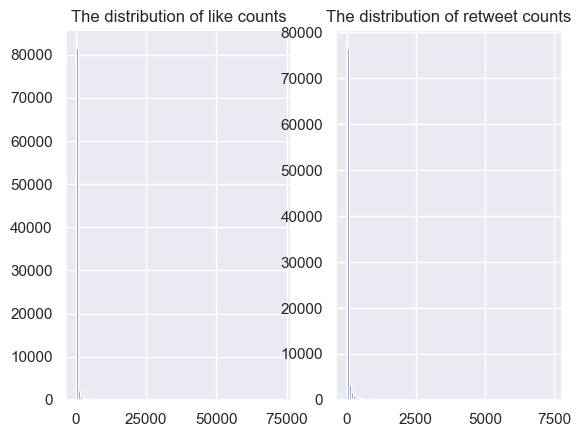

In [69]:
# Plot the distribution of list1
plt.subplot(1, 2, 1)
plt.hist(like_counts, bins=100)
plt.title("The distribution of like counts")

# Plot the distribution of list2
plt.subplot(1, 2, 2)
plt.hist(retweet_counts, bins=100)
plt.title("The distribution of retweet counts")
plt.show()

## 1. Does multimedia attachment in a tweet affect its user engagement?

- Yes, the Mann–Whitney U test is a nonparametric test of the null hypothesis that, for randomly selected values X and Y from two populations, the probability of X being greater than Y is equal to the probability of Y being greater than X. Below, it is shown that the test is significant and rejects null hypothesis for the tweets with/witout multimedia attachment. In visual inspection, the boxplot are so tiny that the difference can't be seen but it can be seen that the statistics like IQR and median values are different. The tweets with multimedia attachment attract more likes and retweets.

In [128]:
likes_without_media = df[df.has_media != 1].like_count.to_list()
likes_with_media = df[df.has_media == 1].like_count.to_list()
print(
    f"""
The number of tweets with media: {len(likes_with_media)},
The number of tweets without media: {len(likes_without_media)},
"""
)
result = mannwhitneyu(likes_with_media, likes_without_media)
print(
    f"""
H0 hypothesis is rejected. The mean of like counts for tweets with and without media are significantly different
Test statistic: {result.statistic}, p-value: {result.pvalue}
"""
)


The number of tweets with media: 36893,
The number of tweets without media: 49640,


H0 hypothesis is rejected. The mean of like counts for tweets with and without media are significantly different
Test statistic: 1094904997.5, p-value: 0.0



In [129]:
retweets_without_media = df[df.has_media != 1].retweet_count.to_list()
retweets_with_media = df[df.has_media == 1].retweet_count.to_list()
print(
    f"""
The number of tweets with media: {len(retweets_with_media)},
The number of tweets without media: {len(retweets_without_media)},
"""
)
result = mannwhitneyu(retweets_with_media, retweets_without_media)
print(
    f"""
H0 hypothesis is rejected. The mean of like counts for tweets with and without media are significantly different
Test statistic: {result.statistic}, p-value: {result.pvalue}
"""
)


The number of tweets with media: 36893,
The number of tweets without media: 49640,


H0 hypothesis is rejected. The mean of like counts for tweets with and without media are significantly different
Test statistic: 1077962128.0, p-value: 0.0



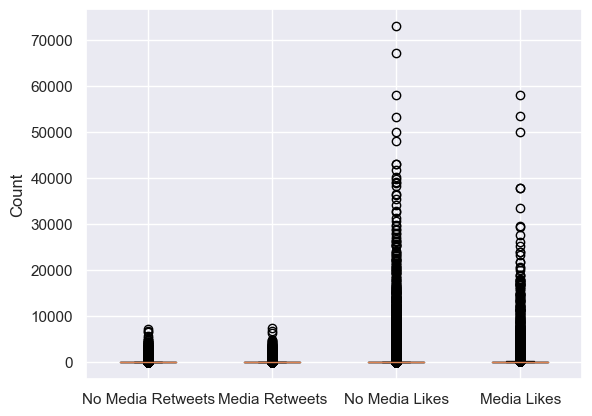

In [88]:
plt.boxplot(
    [
        df.loc[df["has_media"] == 0, "retweet_count"],
        df.loc[df["has_media"] == 1, "retweet_count"],
        df.loc[df["has_media"] == 0, "like_count"],
        df.loc[df["has_media"] == 1, "like_count"],
    ]
)
plt.xticks(
    [1, 2, 3, 4],
    ["No Media Retweets", "Media Retweets", "No Media Likes", "Media Likes"],
)
plt.ylabel("Count")
plt.show()

In [73]:
df.loc[df["has_media"] == 0, "retweet_count"].describe()

count    49640.000000
mean        39.739545
std        191.310164
min          0.000000
25%          2.000000
50%          5.000000
75%         15.000000
max       7150.000000
Name: retweet_count, dtype: float64

In [74]:
df.loc[df["has_media"] == 1, "retweet_count"].describe()

count    36893.000000
mean        69.596861
std        227.745718
min          0.000000
25%          2.000000
50%          8.000000
75%         35.000000
max       7413.000000
Name: retweet_count, dtype: float64

In [75]:
df.loc[df["has_media"] == 0, "like_count"].describe()

count    49640.000000
mean       240.935717
std       1524.515103
min          0.000000
25%          4.000000
50%         13.000000
75%         44.000000
max      73017.000000
Name: like_count, dtype: float64

In [76]:
df.loc[df["has_media"] == 1, "like_count"].describe()

count    36893.000000
mean       217.303825
std       1108.193270
min          0.000000
25%          7.000000
50%         27.000000
75%        107.000000
max      57974.000000
Name: like_count, dtype: float64

## 2. Does the sentiment of a tweet affect its user engagement?
- Yes, according to Spearman's R correlation coefficient, there is a positive correlation between sentiment and like/retweet counts. This is also confirmed via visual inspection based on hexagonally-binned scatterplots.

In [77]:
df_with_sentiment_scores = df[df.lang.isin(["en", "tr", "de", "fr"])]
assert set(df_with_sentiment_scores.lang.unique()) == set(["en", "tr", "de", "fr"])

In [78]:
res = spearmanr(
    df_with_sentiment_scores.sentiment.to_list(),
    df_with_sentiment_scores.like_count.to_list(),
    alternative="greater",
)
print(
    f"""
H0 hypothesis is rejected. There is a positive correlation between like counts and the sentiment of the tweets.
Correlation: {res.correlation}, p-value: {res.pvalue}
"""
)


H0 hypothesis is rejected. There is a positive correlation between like counts and the sentiment of the tweets.
Correlation: 0.07007628472138114, p-value: 1.0306959135591092e-91



In [79]:
res = spearmanr(
    df_with_sentiment_scores.sentiment.to_list(),
    df_with_sentiment_scores.retweet_count.to_list(),
    alternative="greater",
)
print(
    f"""
H0 hypothesis is rejected. There is a positive correlation between retweet counts and the sentiment of the tweets.
Correlation: {res.correlation}, p-value: {res.pvalue}
"""
)


H0 hypothesis is rejected. There is a positive correlation between retweet counts and the sentiment of the tweets.
Correlation: 0.05569700879426289, p-value: 1.1064654269600274e-58



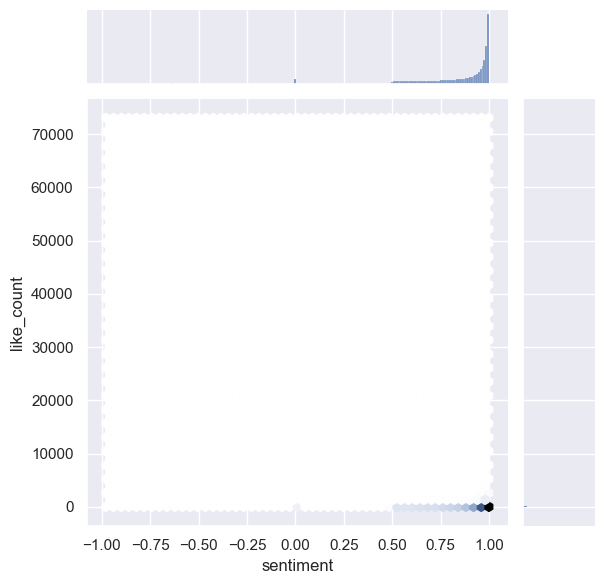

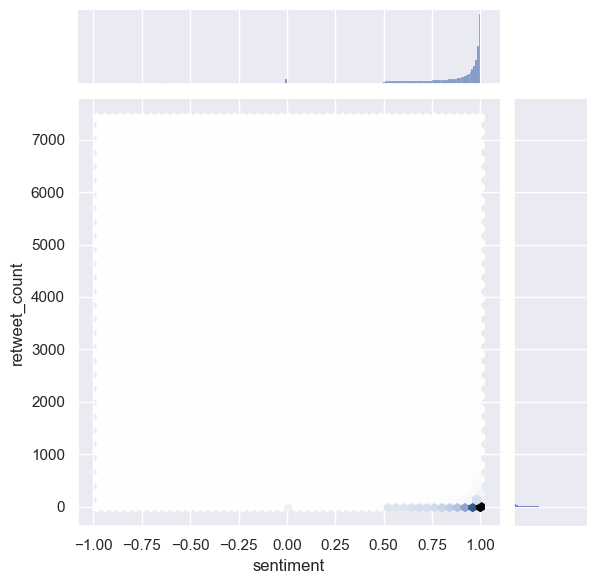

In [81]:
# Plot a hexbin plot for the x and y columns in the first subplot
sns.jointplot(x="sentiment", y="like_count", data=df_with_sentiment_scores, kind="hex")
axs[0].set_xlabel("sentiment")
axs[0].set_ylabel("like_count")

# Plot a hexbin plot for the x and z columns in the second subplot
sns.jointplot(
    x="sentiment",
    y="retweet_count",
    data=df_with_sentiment_scores,
    kind="hex",
)
axs[1].set_xlabel("sentiment")
axs[1].set_ylabel("retweet_count")

plt.show()

## 3. Does the emotion of a tweet affect its user engagement?

- Yes, one test is done for each emotion and Spearman's r test shows significant positive correlations with all emotions with like/retweet count apart from trust and like count correlation.

In [13]:
emotions = [
    "anger",
    "fear",
    "anticipation",
    "trust",
    "surprise",
    "sadness",
    "joy",
    "disgust",
]
for emotion in emotions:
    emotion_df = df[~df[emotion].isna()]

    res = spearmanr(
        emotion_df[emotion].to_list(),
        emotion_df.like_count.to_list(),
        alternative="greater",
    )
    if res.pvalue < 0.05:
        print(
            f"""
        H0 hypothesis is rejected. There is a significant positive correlation between like counts and {emotion}.
        Correlation: {res.correlation}, p-value: {res.pvalue}
        """
        )
    else:
        print(
            f"""
        H0 hypothesis is not rejected. There is no significant correlation between like counts and {emotion}.
        Correlation: {res.correlation}, p-value: {res.pvalue}
        """
        )


        H0 hypothesis is rejected. There is a significant positive correlation between like counts and anger.
        Correlation: 0.04573122558424203, p-value: 1.4089555416896011e-31
        

        H0 hypothesis is rejected. There is a significant positive correlation between like counts and fear.
        Correlation: 0.057130183824601305, p-value: 3.569409937858113e-48
        

        H0 hypothesis is rejected. There is a significant positive correlation between like counts and anticipation.
        Correlation: 0.06150962525121458, p-value: 1.5943959674550123e-55
        

        H0 hypothesis is not rejected. There is no significant correlation between like counts and trust.
        Correlation: 0.0059362491407218086, p-value: 0.06562324260181629
        

        H0 hypothesis is rejected. There is a significant positive correlation between like counts and surprise.
        Correlation: 0.03755382448263811, p-value: 6.435163377514879e-22
        

        H0 hypothesis is r

In [16]:
for emotion in emotions:
    emotion_df = df[~df[emotion].isna()]

    res = spearmanr(
        emotion_df[emotion].to_list(),
        emotion_df.retweet_count.to_list(),
        alternative="greater",
    )
    if res.pvalue < 0.05:
        print(
            f"""
        H0 hypothesis is rejected. There is a significant positive correlation between retweet counts and {emotion}.
        Correlation: {res.correlation}, p-value: {res.pvalue}
        """
        )
    else:
        print(
            f"""
        H0 hypothesis is not rejected. There is no significant correlation between retweet counts and {emotion}.
        Correlation: {res.correlation}, p-value: {res.pvalue}
        """
        )


        H0 hypothesis is rejected. There is a significant positive correlation between retweet counts and anger.
        Correlation: 0.07172470194826953, p-value: 8.884500000068638e-75
        

        H0 hypothesis is rejected. There is a significant positive correlation between retweet counts and fear.
        Correlation: 0.08127593058015947, p-value: 1.8322682991175014e-95
        

        H0 hypothesis is rejected. There is a significant positive correlation between retweet counts and anticipation.
        Correlation: 0.04184710201367878, p-value: 9.340228363642272e-27
        

        H0 hypothesis is rejected. There is a significant positive correlation between retweet counts and trust.
        Correlation: 0.021721202111600293, p-value: 1.6672344164699186e-08
        

        H0 hypothesis is rejected. There is a significant positive correlation between retweet counts and surprise.
        Correlation: 0.03229320734067942, p-value: 1.0863507734925709e-16
        

      

## 4. Does the language of a tweet affect its user engagement?

In [20]:
H, p = kruskal(df["new_lang"].to_list(), df["like_count"].to_list())

# Print the test results
print("Kruskal-Wallis H test results:")
print(f"H-statistic: {H}")
print(f"p-value: {p}")

Kruskal-Wallis H test results:
H-statistic: 144520.86533930188
p-value: 0.0


/Users/hasansalimkanmaz/environments/kuleuven-thesis/lib/python3.10/site-packages/scipy/stats/_stats_py.py:112: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  warnings.warn("The input array could not be properly "


In [21]:
group1_values = df["new_lang"].unique()

# Perform Kruskal-Wallis H test for each combination of two in group1_values
for group1_pair in combinations(group1_values, 2):
    group1_pair_df = df.loc[df["new_lang"].isin(group1_pair)]
    H, p = kruskal(
        group1_pair_df["new_lang"].to_list(), group1_pair_df["like_count"].to_list()
    )
    print(f"Kruskal-Wallis H test results for group1 values {group1_pair}:")
    print(f"H-statistic: {H}")
    print(f"p-value: {p}")

Kruskal-Wallis H test results for group1 values ('tr', 'very_short'):
H-statistic: 140823.51254420957
p-value: 0.0
Kruskal-Wallis H test results for group1 values ('tr', 'en'):
H-statistic: 141053.9741910073
p-value: 0.0
Kruskal-Wallis H test results for group1 values ('tr', 'other'):
H-statistic: 139320.6919696856
p-value: 0.0
Kruskal-Wallis H test results for group1 values ('tr', 'short_text'):
H-statistic: 138691.66604422368
p-value: 0.0
Kruskal-Wallis H test results for group1 values ('very_short', 'en'):
H-statistic: 7389.91675552772
p-value: 0.0
Kruskal-Wallis H test results for group1 values ('very_short', 'other'):
H-statistic: 4867.170159047441
p-value: 0.0
Kruskal-Wallis H test results for group1 values ('very_short', 'short_text'):
H-statistic: 4072.450293092248
p-value: 0.0
Kruskal-Wallis H test results for group1 values ('en', 'other'):
H-statistic: 5234.305018201159
p-value: 0.0
Kruskal-Wallis H test results for group1 values ('en', 'short_text'):
H-statistic: 4448.863684

In [85]:
df.groupby("new_lang")["like_count", "retweet_count"].describe()

/var/folders/z5/hjyvlbm54v1cpt9s019vbv9w0000gn/T/ipykernel_24642/3991137282.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df.groupby("new_lang")["like_count", "retweet_count"].describe()


like_count                                                          \
                count        mean          std  min  25%   50%   75%      max   
new_lang                                                                        
en             2496.0  297.172676  1824.628413  0.0  3.0  11.0  36.0  53460.0   
other           797.0  108.393977  1119.151764  0.0  2.0   7.0  33.0  28136.0   
short_text      163.0  250.006135  1211.800459  0.0  4.5  12.0  65.0  12497.0   
tr            80804.0  234.857123  1362.701527  0.0  6.0  19.0  70.0  73017.0   
very_short     2273.0   57.527497   665.203715  0.0  1.0   3.0  12.0  18951.0   

           retweet_count                                                      
                   count       mean         std  min  25%  50%   75%     max  
new_lang                                                                      
en                2496.0  74.735577  308.842354  0.0  1.0  5.0  18.0  6762.0  
other              797.0  13.606023   81.297088  0.0  0.0  2.0   7.0  1711.0  
short_text         163.0  30.607362  143.298033  0.0  1.0  3.0   7.0  1256.0  
tr               80804.0  53.447243  207.729065  0.0  2.0  6.0  21.0  7413.0  
very_short        2273.0   8.439947   62.304151  0.0  0.0  1.0   4.0  1467.0

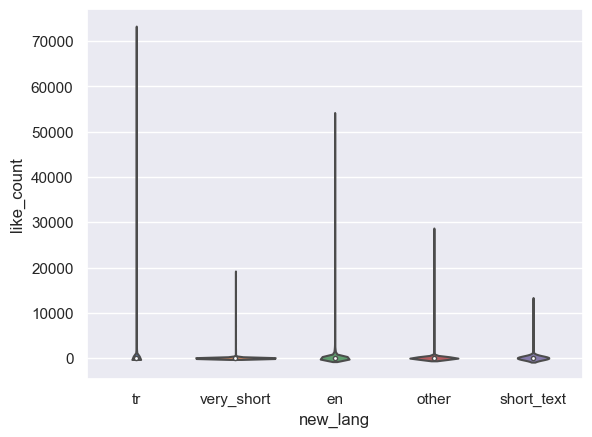

In [90]:
sns.violinplot(x="new_lang", y="like_count", data=df)
plt.show()

## 5. Does including the trend topic of the day in a tweet affect its user engagement?

In [22]:
res = spearmanr(
    df.n_trend_topics.to_list(),
    df.like_count.to_list(),
    alternative="less",
)
print(
    f"""
H0 hypothesis is rejected. There is a negative correlation between like counts and the number of the trend topics.
Correlation: {res.correlation}, p-value: {res.pvalue}
"""
)


H0 hypothesis is rejected. There is a negative correlation between like counts and the number of the trend topics.
Correlation: -0.146508968440363, p-value: 0.0



In [107]:
res = spearmanr(
    df.n_trend_topics.to_list(),
    df.retweet_count.to_list(),
    alternative="less",
)
print(
    f"""
H0 hypothesis is rejected. There is a negative correlation between retweet counts and the number of the trend topics.
Correlation: {res.correlation}, p-value: {res.pvalue}
"""
)


H0 hypothesis is rejected. There is a negative correlation between retweet counts and the number of the trend topics.
Correlation: -0.01617512029960235, p-value: 9.756893802633943e-07



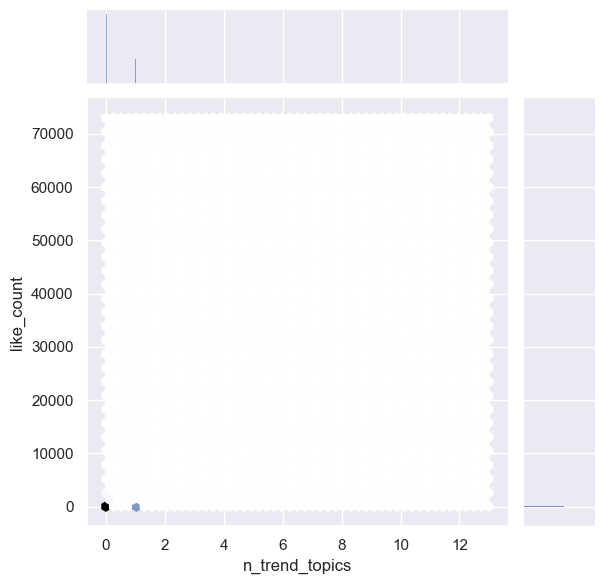

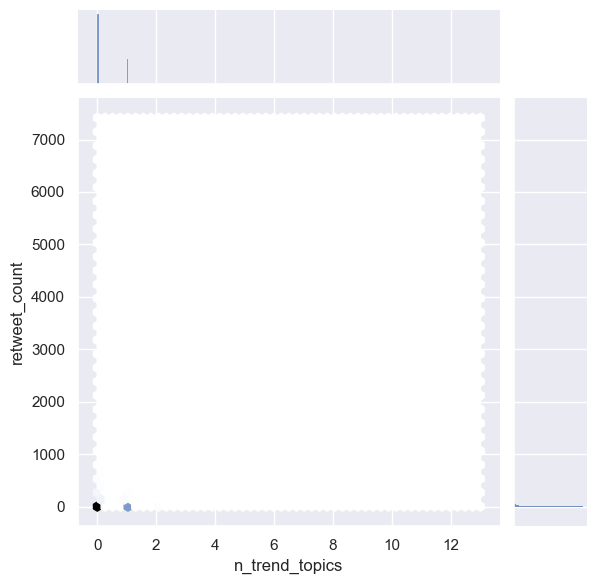

In [108]:
sns.jointplot(x="n_trend_topics", y="like_count", data=df, kind="hex")
axs[0].set_xlabel("n_trend_topics")
axs[0].set_ylabel("like_count")

sns.jointplot(
    x="n_trend_topics",
    y="retweet_count",
    data=df,
    kind="hex",
)
axs[1].set_xlabel("n_trend_topics")
axs[1].set_ylabel("retweet_count")

plt.show()

## 6. Does the creation time of a tweet affect its user engagement?

In [13]:
a = df[['created_at', 'like_count', 'retweet_count']].copy()

In [14]:
a['created_at_hour'] = a['created_at'].dt.hour

Like count

In [19]:
kruskal_test = kruskal(
    a.loc[a['created_at_hour']==0, 'like_count'],
    a.loc[a['created_at_hour']==1, 'like_count'],
    a.loc[a['created_at_hour']==2, 'like_count'],
    a.loc[a['created_at_hour']==3, 'like_count'],
    a.loc[a['created_at_hour']==4, 'like_count'],
    a.loc[a['created_at_hour']==5, 'like_count'],
    a.loc[a['created_at_hour']==6, 'like_count'],
    a.loc[a['created_at_hour']==7, 'like_count'],
    a.loc[a['created_at_hour']==8, 'like_count'],
    a.loc[a['created_at_hour']==9, 'like_count'],
    a.loc[a['created_at_hour']==10, 'like_count'],
    a.loc[a['created_at_hour']==11, 'like_count'],
    a.loc[a['created_at_hour']==12, 'like_count'],
    a.loc[a['created_at_hour']==13, 'like_count'],
    a.loc[a['created_at_hour']==14, 'like_count'],
    a.loc[a['created_at_hour']==15, 'like_count'],
    a.loc[a['created_at_hour']==16, 'like_count'],
    a.loc[a['created_at_hour']==17, 'like_count'],
    a.loc[a['created_at_hour']==18, 'like_count'],
    a.loc[a['created_at_hour']==19, 'like_count'],
    a.loc[a['created_at_hour']==20, 'like_count'],
    a.loc[a['created_at_hour']==21, 'like_count'],
    a.loc[a['created_at_hour']==22, 'like_count'],
    a.loc[a['created_at_hour']==23, 'like_count']
)

Created hour has an effect on like count

In [20]:
print("Kruskal-Wallis test:")
print("H statistic:", kruskal_test.statistic)
print("p-value:", kruskal_test.pvalue)

Kruskal-Wallis test:
H statistic: 4926.436839696231
p-value: 0.0


In [24]:
# Dunn's post hoc test
dunn_test = posthoc_dunn(a, val_col="like_count", group_col="created_at_hour", p_adjust="holm")

In [ ]:
s = pd.DataFrame(np.triu(dunn_test.round(3)), index=dunn_test.index, columns=dunn_test.columns)

- The below table shows the p-value of the pairwise comparison
- if p-value is less than 0.05, then we conclude there is a sigfinicant difference between the two groups 
- 19h is the created time with the lowest likes, and might not be much different from tweets at 1h and 2h
- 21h is the created time with the highest likes, and might not be much different from tweets at 22h and 4h

Dunn's post hoc test:


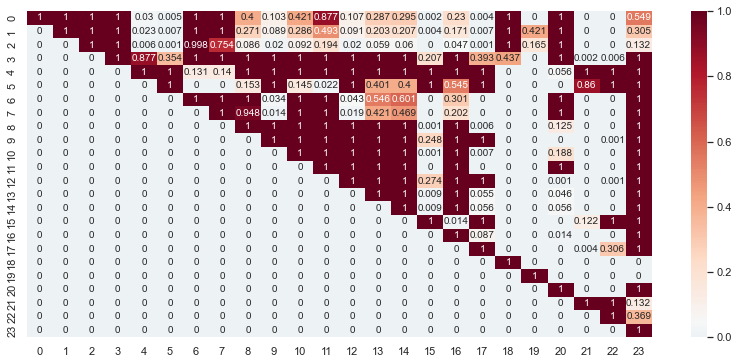

In [56]:
print("Dunn's post hoc test:")
plt.figure(figsize=(14, 6))
sns.heatmap(s, cmap='RdBu_r', annot=True, center=0.05, fmt='.5g');

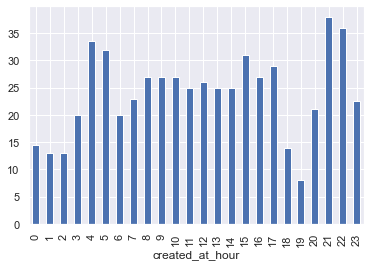

In [91]:
a.groupby('created_at_hour')['like_count'].median().plot.bar();

Retweet count

In [93]:
kruskal_test = kruskal(
    a.loc[a['created_at_hour']==0, 'retweet_count'],
    a.loc[a['created_at_hour']==1, 'retweet_count'],
    a.loc[a['created_at_hour']==2, 'retweet_count'],
    a.loc[a['created_at_hour']==3, 'retweet_count'],
    a.loc[a['created_at_hour']==4, 'retweet_count'],
    a.loc[a['created_at_hour']==5, 'retweet_count'],
    a.loc[a['created_at_hour']==6, 'retweet_count'],
    a.loc[a['created_at_hour']==7, 'retweet_count'],
    a.loc[a['created_at_hour']==8, 'retweet_count'],
    a.loc[a['created_at_hour']==9, 'retweet_count'],
    a.loc[a['created_at_hour']==10, 'retweet_count'],
    a.loc[a['created_at_hour']==11, 'retweet_count'],
    a.loc[a['created_at_hour']==12, 'retweet_count'],
    a.loc[a['created_at_hour']==13, 'retweet_count'],
    a.loc[a['created_at_hour']==14, 'retweet_count'],
    a.loc[a['created_at_hour']==15, 'retweet_count'],
    a.loc[a['created_at_hour']==16, 'retweet_count'],
    a.loc[a['created_at_hour']==17, 'retweet_count'],
    a.loc[a['created_at_hour']==18, 'retweet_count'],
    a.loc[a['created_at_hour']==19, 'retweet_count'],
    a.loc[a['created_at_hour']==20, 'retweet_count'],
    a.loc[a['created_at_hour']==21, 'retweet_count'],
    a.loc[a['created_at_hour']==22, 'retweet_count'],
    a.loc[a['created_at_hour']==23, 'retweet_count']
)

Created hour has an effect on retweet count

In [94]:
print("Kruskal-Wallis test:")
print("H statistic:", kruskal_test.statistic)
print("p-value:", kruskal_test.pvalue)

Kruskal-Wallis test:
H statistic: 1641.6240008903123
p-value: 0.0


In [95]:
# Dunn's post hoc test
dunn_test = posthoc_dunn(a, val_col="retweet_count", group_col="created_at_hour", p_adjust="holm")

In [96]:
s = pd.DataFrame(np.triu(dunn_test.round(3)), index=dunn_test.index, columns=dunn_test.columns)

- The below table shows the p-value of the pairwise comparison
- if p-value is less than 0.05, then we conclude there is a sigfinicant difference between the two groups 
- 19h is the created time with the lowest likes, and might not be much different from tweets at 1h and 2h
- 21h is the created time with the highest likes, and might not be much different from tweets at 22h and 4h

Dunn's post hoc test:


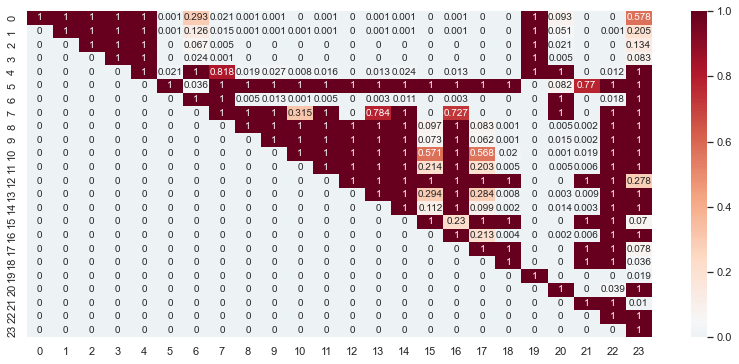

In [101]:
print("Dunn's post hoc test:")
plt.figure(figsize=(14, 6))
sns.heatmap(s, cmap='RdBu_r', annot=True, center=0.05, fmt='.5g');

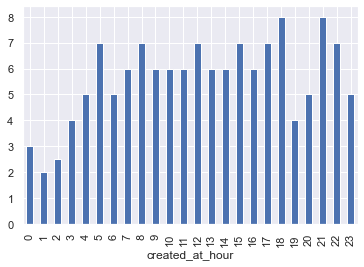

In [99]:
a.groupby('created_at_hour')['retweet_count'].median().plot.bar();

## 7. Does including hashtags in a tweet affect its user engagement? 

In [23]:
res = spearmanr(
    df.n_hashtags.to_list(),
    df.like_count.to_list(),
    alternative="less",
)
print(
    f"""
H0 hypothesis is rejected. There is a negative correlation between like counts and the number of the trend topics.
Correlation: {res.correlation}, p-value: {res.pvalue}
"""
)


H0 hypothesis is rejected. There is a negative correlation between like counts and the number of the trend topics.
Correlation: -0.06700737101232843, p-value: 5.602693979091816e-87



In [24]:
res = spearmanr(
    df.n_hashtags.to_list(),
    df.retweet_count.to_list(),
    alternative="greater",
)
print(
    f"""
H0 hypothesis is rejected. There is a positive correlation between retweet counts and the number of the trend topics.
Correlation: {res.correlation}, p-value: {res.pvalue}
"""
)


H0 hypothesis is rejected. There is a positive correlation between retweet counts and the number of the trend topics.
Correlation: 0.012377358209511169, p-value: 0.0001357528854822984



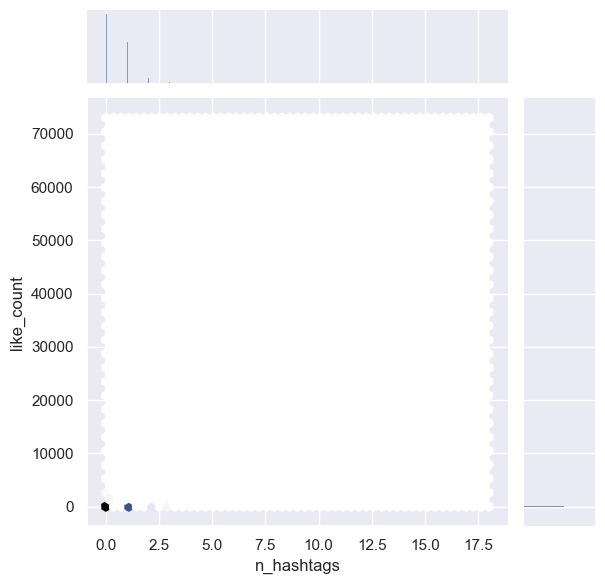

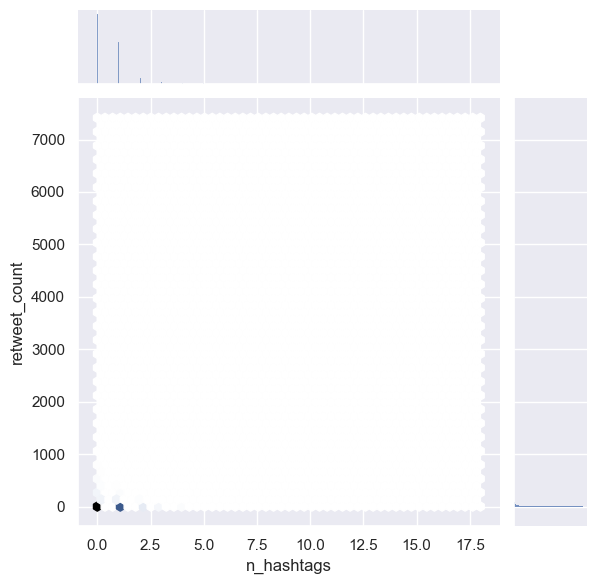

In [114]:
sns.jointplot(x="n_hashtags", y="like_count", data=df, kind="hex")
axs[0].set_xlabel("n_hashtags")
axs[0].set_ylabel("like_count")

sns.jointplot(
    x="n_hashtags",
    y="retweet_count",
    data=df,
    kind="hex",
)
axs[1].set_xlabel("n_hashtags")
axs[1].set_ylabel("retweet_count")

plt.show()

In [118]:
df.groupby("n_hashtags")["like_count", "retweet_count"].describe()

/var/folders/z5/hjyvlbm54v1cpt9s019vbv9w0000gn/T/ipykernel_24642/3910865875.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df.groupby("n_hashtags")["like_count", "retweet_count"].describe()


like_count                                                      \
                count        mean          std   min    25%   50%     75%   
n_hashtags                                                                  
0             50361.0  325.237346  1733.050472   0.0   6.00  20.0   78.00   
1             29987.0   93.280988   470.901902   0.0   4.00  13.0   48.00   
2              3931.0  145.039685   515.838370   0.0   8.00  26.0  103.50   
3              1360.0  117.927206   617.745057   0.0   8.00  25.5   73.25   
4               563.0   85.142096   467.844540   0.0   9.00  17.0   38.00   
5               169.0   68.792899   193.755058   0.0   7.00  15.0   44.00   
6                95.0   59.410526   107.697221   0.0   6.00  27.0   75.00   
7                39.0   31.743590    41.883119   0.0   4.50  14.0   43.50   
8                10.0   66.100000   136.169380   2.0   9.75  17.0   51.25   
9                10.0  275.500000   689.464567   6.0   7.25  14.0   63.25   
10                4.0   14.250000    19.939492   2.0   3.50   5.5   16.25   
11                1.0    6.000000          NaN   6.0   6.00   6.0    6.00   
12                1.0   34.000000          NaN  34.0  34.00  34.0   34.00   
13                1.0    2.000000          NaN   2.0   2.00   2.0    2.00   
18                1.0   54.000000          NaN  54.0  54.00  54.0   54.00   

                    retweet_count                                            \
                max         count       mean         std   min    25%   50%   
n_hashtags                                                                    
0           73017.0       50361.0  65.701654  253.339990   0.0   2.00   6.0   
1           22041.0       29987.0  32.844266  114.169276   0.0   2.00   6.0   
2           19270.0        3931.0  46.044264  129.283668   0.0   2.00   7.0   
3           17848.0        1360.0  34.135294  148.595740   0.0   2.00   7.0   
4            8657.0         563.0  22.241563  116.677424   0.0   3.00   7.0   
5            1516.0         169.0  18.236686   54.176439   0.0   2.00   5.0   
6             744.0          95.0  23.336842   45.070774   0.0   3.50   9.0   
7             173.0          39.0  13.384615   24.602755   0.0   1.00   6.0   
8             449.0          10.0  21.300000   37.694827   0.0   3.25   6.5   
9            2211.0          10.0  57.800000  149.148546   0.0   2.75   6.5   
10             44.0           4.0   6.500000   11.030261   0.0   0.75   1.5   
11              6.0           1.0   3.000000         NaN   3.0   3.00   3.0   
12             34.0           1.0   7.000000         NaN   7.0   7.00   7.0   
13              2.0           1.0   2.000000         NaN   2.0   2.00   2.0   
18             54.0           1.0  10.000000         NaN  10.0  10.00  10.0   

                           
              75%     max  
n_hashtags                 
0           22.00  7150.0  
1           18.00  7413.0  
2           25.00  2335.0  
3           28.00  3675.0  
4           15.00  2218.0  
5           12.00   518.0  
6           32.50   394.0  
7           13.00   139.0  
8           19.50   124.0  
9           25.50   481.0  
10           7.25    23.0  
11           3.00     3.0  
12           7.00     7.0  
13           2.00     2.0  
18          10.00    10.0

## 8. Is the user engagement of a tweet containing political content different from the tweet without political content?

In [25]:
likes_without_political_context = df[
    df.political_context_annotation != 1
].like_count.to_list()
likes_with_political_context = df[
    df.political_context_annotation == 1
].like_count.to_list()
print(
    f"""
The number of tweets with political_context: {len(likes_with_political_context)},
The number of tweets without political_context: {len(likes_without_political_context)},
"""
)


The number of tweets with political_context: 3070,
The number of tweets without political_context: 83463,



In [29]:
result = mannwhitneyu(likes_with_political_context, likes_without_political_context)
print(
    f"""
H0 hypothesis is rejected. The mean of like counts for tweets with and without political context are significantly different
Test statistic: {result.statistic}, p-value: {result.pvalue}
"""
)


H0 hypothesis is rejected. The mean of like counts for tweets with and without political context are significantly different
Test statistic: 134516290.0, p-value: 2.4740332224471758e-06



In [27]:
retweets_without_political_context = df[
    df.political_context_annotation != 1
].retweet_count.to_list()
retweets_with_political_context = df[
    df.political_context_annotation == 1
].retweet_count.to_list()
print(
    f"""
The number of tweets with political_context: {len(retweets_with_political_context)},
The number of tweets without political_context: {len(retweets_without_political_context)},
"""
)


The number of tweets with political_context: 3070,
The number of tweets without political_context: 83463,



In [30]:
result = mannwhitneyu(
    retweets_with_political_context, retweets_without_political_context
)
print(
    f"""
H0 hypothesis is rejected. The mean of retweet counts for tweets with and without political context are significantly different
Test statistic: {result.statistic}, p-value: {result.pvalue}
"""
)


H0 hypothesis is rejected. The mean of retweet counts for tweets with and without political context are significantly different
Test statistic: 133513458.5, p-value: 6.923736124860105e-05



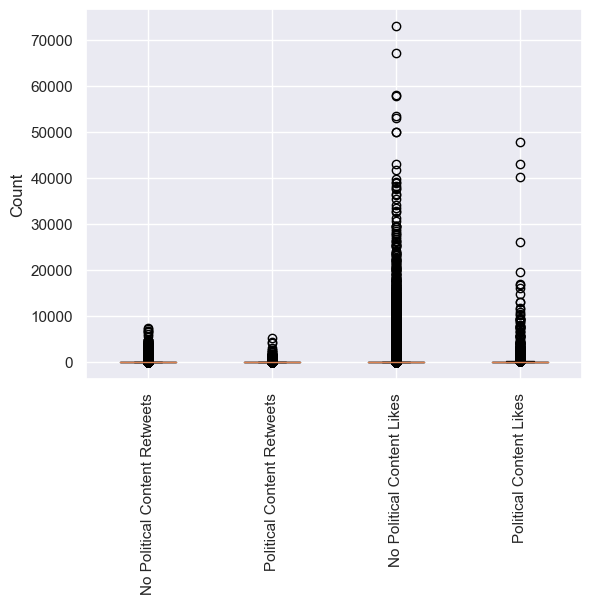

In [31]:
plt.boxplot(
    [
        df.loc[df["political_context_annotation"] == 0, "retweet_count"],
        df.loc[df["political_context_annotation"] == 1, "retweet_count"],
        df.loc[df["political_context_annotation"] == 0, "like_count"],
        df.loc[df["political_context_annotation"] == 1, "like_count"],
    ]
)
plt.xticks(
    [1, 2, 3, 4],
    [
        "No Political Content Retweets",
        "Political Content Retweets",
        "No Political Content Likes",
        "Political Content Likes",
    ],
)
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.show()

In [32]:
df.groupby("political_context_annotation")["like_count", "retweet_count"].describe()

/var/folders/z5/hjyvlbm54v1cpt9s019vbv9w0000gn/T/ipykernel_55756/2960214711.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df.groupby("political_context_annotation")["like_count", "retweet_count"].describe()


like_count                                     \
                                  count        mean          std  min  25%   
political_context_annotation                                                 
False                           83463.0  226.503277  1338.883998  0.0  5.0   
True                             3070.0  349.314658  1895.561912  0.0  6.0   

                                                  retweet_count             \
                               50%   75%      max         count       mean   
political_context_annotation                                                 
False                         17.0  66.0  73017.0       83463.0  51.965709   
True                          22.0  75.0  47967.0        3070.0  66.154397   

                                                                       
                                     std  min  25%  50%   75%     max  
political_context_annotation                                           
False                         206.514962  0.0  2.0  6.0  20.0  7413.0  
True                          248.181543  0.0  2.0  7.0  28.0  5263.0

## 9. Does an important societal event affect the user engagement of a tweet up until 7 days?

In [42]:
lowest_pvalue = 1
for alternative in ["less", "greater", "two-sided"]:
    res = spearmanr(
        df.posted_during_an_important_event.to_list(),
        df.like_count.to_list(),
        alternative=alternative,
    )
    lowest_pvalue = min(lowest_pvalue, res.pvalue)

if lowest_pvalue > 0.05:
    print(
        f"""
    H0 hypothesis is not rejected. There is a NO correlation between like counts and whether the tweet is posted during an important event.
    """
    )


    H0 hypothesis is not rejected. There is a NO correlation between like counts and whether the tweet is posted during an important event.
    


In [51]:
res = spearmanr(
    df.posted_during_an_important_event.to_list(),
    df.retweet_count.to_list(),
    alternative="less",
)

print(
    f"""
H0 hypothesis is rejected. There is a negative correlation between retweet counts and whether the tweet is posted during an important event.
Correlation: {res.correlation}, p-value: {res.pvalue}
"""
)


H0 hypothesis is rejected. There is a negative correlation between retweet counts and whether the tweet is posted during an important event.
Correlation: -0.005656021026035797, p-value: 0.04807697731214641



## 10. Is the topic of the tweet affect its popularity?

In [54]:
H, p = kruskal(df["sttm_topic"].to_list(), df["like_count"].to_list())

# Print the test results
print("Kruskal-Wallis H test results:")
print(f"H-statistic: {H}")
print(f"p-value: {p}")

Kruskal-Wallis H test results:
H-statistic: 129885.54397304611
p-value: 0.0


/Users/hasansalimkanmaz/environments/kuleuven-thesis/lib/python3.10/site-packages/scipy/stats/_stats_py.py:112: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  warnings.warn("The input array could not be properly "


In [56]:
group1_values = df["sttm_topic"].unique()

# Perform Kruskal-Wallis H test for each combination of two in group1_values
for group1_pair in combinations(group1_values, 2):
    group1_pair_df = df.loc[df["sttm_topic"].isin(group1_pair)]
    H, p = kruskal(
        group1_pair_df["sttm_topic"].to_list(), group1_pair_df["like_count"].to_list()
    )
    if p > 0.05:
        print(f"Kruskal-Wallis H test results for group1 values {group1_pair}:")
        print(f"H-statistic: {H}")
        print(f"p-value: {p}")

In [57]:
# Perform Kruskal-Wallis H test for each combination of two in group1_values
for group1_pair in combinations(group1_values, 2):
    group1_pair_df = df.loc[df["sttm_topic"].isin(group1_pair)]
    H, p = kruskal(
        group1_pair_df["sttm_topic"].to_list(),
        group1_pair_df["retweet_count"].to_list(),
    )
    if p > 0.05:
        print(f"Kruskal-Wallis H test results for group1 values {group1_pair}:")
        print(f"H-statistic: {H}")
        print(f"p-value: {p}")

## 11. Users characteristics

### Gender

In [5]:
a = df[['gender_of_author', 'like_count', 'retweet_count']].copy()

Like count

In [7]:
kruskal_test = kruskal(
    a.loc[a['gender_of_author']=='ORG', 'like_count'],
    a.loc[a['gender_of_author']=='M', 'like_count'],
    a.loc[a['gender_of_author']=='F', 'like_count']
)

In [8]:
print("Kruskal-Wallis test:")
print("H statistic:", kruskal_test.statistic)
print("p-value:", kruskal_test.pvalue)

Kruskal-Wallis test:
H statistic: 9815.689128044714
p-value: 0.0


In [9]:
# Dunn's post hoc test
dunn_test = posthoc_dunn(a, val_col="like_count", group_col="gender_of_author", p_adjust="holm")

In [12]:
s = pd.DataFrame(np.triu(dunn_test.round(5)), index=dunn_test.index, columns=dunn_test.columns)

Dunn's post hoc test:


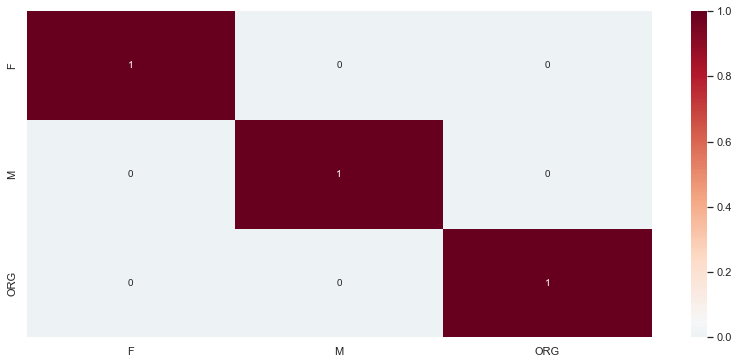

In [13]:
print("Dunn's post hoc test:")
plt.figure(figsize=(14, 6))
sns.heatmap(s, cmap='RdBu_r', annot=True, center=0.05, fmt='.5g');

In [15]:
kruskal_test = kruskal(
    a.loc[a['gender_of_author']=='ORG', 'retweet_count'],
    a.loc[a['gender_of_author']=='M', 'retweet_count'],
    a.loc[a['gender_of_author']=='F', 'retweet_count']
)

In [16]:
print("Kruskal-Wallis test:")
print("H statistic:", kruskal_test.statistic)
print("p-value:", kruskal_test.pvalue)

Kruskal-Wallis test:
H statistic: 1298.9497760765366
p-value: 8.642511980526671e-283


In [17]:
# Dunn's post hoc test
dunn_test = posthoc_dunn(a, val_col="like_count", group_col="gender_of_author", p_adjust="holm")

In [21]:
dunn_test

,F,M,ORG
F,1.000000e+00,6.469625e-150,0.0
M,6.469625e-150,1.000000e+00,0.0
ORG,0.000000e+00,0.000000e+00,1.0


### Verified

In [31]:
def check_mannwhitneyu(data, feat, target):
    data_yes = data[data[feat]==1][target]
    data_no = data[data[feat]!=1][target]
    
    print(
        f"""The number of tweets with {feat}: {len(data_yes)},
The number of tweets without {feat}: {len(data_no)},"""
    )
    
    result = mannwhitneyu(data_yes, data_no)
    print(f'Test statistic: {result.statistic} | p-value: {result.pvalue}')

In [32]:
check_mannwhitneyu(df, 'verified_author', 'like_count')

The number of tweets with verified_author: 10539,
The number of tweets without verified_author: 76725,
Test statistic: 519705811.0 | p-value: 0.0


In [33]:
check_mannwhitneyu(df, 'verified_author', 'retweet_count')

The number of tweets with verified_author: 10539,
The number of tweets without verified_author: 76725,
Test statistic: 459711649.5 | p-value: 4.867152287195678e-116


### Profession

In [35]:
df['profession_of_author'].unique()

array(['UNKNOWN', 'LAWYER', 'JOURNALIST', 'POLITICIAN'], dtype=object)

In [36]:
kruskal_test = kruskal(
    df.loc[df['profession_of_author']=='UNKNOWN', 'like_count'],
    df.loc[df['profession_of_author']=='LAWYER', 'like_count'],
    df.loc[df['profession_of_author']=='JOURNALIST', 'like_count'],
    df.loc[df['profession_of_author']=='POLITICIAN', 'like_count'],
)

In [37]:
print("Kruskal-Wallis test:")
print("H statistic:", kruskal_test.statistic)
print("p-value:", kruskal_test.pvalue)

Kruskal-Wallis test:
H statistic: 5773.635913251941
p-value: 0.0


In [38]:
# Dunn's post hoc test
dunn_test = posthoc_dunn(df, val_col="like_count", group_col="profession_of_author", p_adjust="holm")

In [39]:
s = pd.DataFrame(np.triu(dunn_test.round(5)), index=dunn_test.index, columns=dunn_test.columns)

In [41]:
s

,JOURNALIST,LAWYER,POLITICIAN,UNKNOWN
JOURNALIST,1.0,0.0,0.0,0.0
LAWYER,0.0,1.0,0.0,0.0
POLITICIAN,0.0,0.0,1.0,0.0
UNKNOWN,0.0,0.0,0.0,1.0


In [42]:
kruskal_test = kruskal(
    df.loc[df['profession_of_author']=='UNKNOWN', 'retweet_count'],
    df.loc[df['profession_of_author']=='LAWYER', 'retweet_count'],
    df.loc[df['profession_of_author']=='JOURNALIST', 'retweet_count'],
    df.loc[df['profession_of_author']=='POLITICIAN', 'retweet_count'],
)

In [43]:
print("Kruskal-Wallis test:")
print("H statistic:", kruskal_test.statistic)
print("p-value:", kruskal_test.pvalue)

Kruskal-Wallis test:
H statistic: 1820.0969969843256
p-value: 0.0


In [44]:
# Dunn's post hoc test
dunn_test = posthoc_dunn(df, val_col="retweet_count", group_col="profession_of_author", p_adjust="holm")

In [45]:
dunn_test

,JOURNALIST,LAWYER,POLITICIAN,UNKNOWN
JOURNALIST,1.000000e+00,8.424072e-81,0.000000e+00,9.953314e-36
LAWYER,8.424072e-81,1.000000e+00,9.709932e-15,1.035137e-44
POLITICIAN,0.000000e+00,9.709932e-15,1.000000e+00,1.354063e-299
UNKNOWN,9.953314e-36,1.035137e-44,1.354063e-299,1.000000e+00


### Has hashtags

In [46]:
check_mannwhitneyu(df, 'has_hashtags', 'like_count')

The number of tweets with has_hashtags: 36623,
The number of tweets without has_hashtags: 50641,
Test statistic: 833944842.5 | p-value: 1.1008256175368152e-142


In [47]:
check_mannwhitneyu(df, 'has_hashtags', 'retweet_count')

The number of tweets with has_hashtags: 36623,
The number of tweets without has_hashtags: 50641,
Test statistic: 932756614.5 | p-value: 0.13741537169171622


### Has mentions

In [48]:
check_mannwhitneyu(df, 'has_mentions', 'like_count')

The number of tweets with has_mentions: 19948,
The number of tweets without has_mentions: 67316,
Test statistic: 682872707.5 | p-value: 0.00024302020884668622


In [49]:
check_mannwhitneyu(df, 'has_mentions', 'retweet_count')

The number of tweets with has_mentions: 19948,
The number of tweets without has_mentions: 67316,
Test statistic: 704335504.0 | p-value: 4.6316720993160323e-26


In [50]:
df.groupby('has_mentions')['retweet_count'].describe()

,count,mean,std,min,25%,50%,75%,max
has_mentions,,,,,,,,
0,67316.0,47.624844,205.208294,0.0,2.0,6.0,19.0,7413.0
1,19948.0,66.391368,212.765313,0.0,2.0,6.0,28.0,6762.0


### Language

In [51]:
df['new_lang'].unique()

array(['tr', 'short_text', 'en', 'other'], dtype=object)

In [52]:
kruskal_test = kruskal(
    df.loc[df['new_lang']=='tr', 'like_count'],
    df.loc[df['new_lang']=='short_text', 'like_count'],
    df.loc[df['new_lang']=='en', 'like_count'],
    df.loc[df['new_lang']=='other', 'like_count'],
)

In [53]:
print("Kruskal-Wallis test:")
print("H statistic:", kruskal_test.statistic)
print("p-value:", kruskal_test.pvalue)

Kruskal-Wallis test:
H statistic: 1974.3216257060367
p-value: 0.0


In [54]:
# Dunn's post hoc test
dunn_test = posthoc_dunn(df, val_col="like_count", group_col="new_lang", p_adjust="holm")

In [55]:
s = pd.DataFrame(np.triu(dunn_test.round(5)), index=dunn_test.index, columns=dunn_test.columns)

In [56]:
s

,en,other,short_text,tr
en,1.0,0.00004,0.0,0.0
other,0.0,1.00000,0.0,0.0
short_text,0.0,0.00000,1.0,0.0
tr,0.0,0.00000,0.0,1.0


In [57]:
kruskal_test = kruskal(
    df.loc[df['new_lang']=='tr', 'retweet_count'],
    df.loc[df['new_lang']=='short_text', 'retweet_count'],
    df.loc[df['new_lang']=='en', 'retweet_count'],
    df.loc[df['new_lang']=='other', 'retweet_count'],
)

In [58]:
print("Kruskal-Wallis test:")
print("H statistic:", kruskal_test.statistic)
print("p-value:", kruskal_test.pvalue)

Kruskal-Wallis test:
H statistic: 1889.8062769682933
p-value: 0.0


In [59]:
# Dunn's post hoc test
dunn_test = posthoc_dunn(df, val_col="retweet_count", group_col="new_lang", p_adjust="holm")

In [60]:
dunn_test

,en,other,short_text,tr
en,1.000000e+00,1.545965e-31,1.161211e-126,7.174543e-11
other,1.545965e-31,1.000000e+00,1.906527e-06,3.647320e-65
short_text,1.161211e-126,1.906527e-06,1.000000e+00,0.000000e+00
tr,7.174543e-11,3.647320e-65,0.000000e+00,1.000000e+00


### Trend topic

In [61]:
a = df[['n_trend_topics', 'like_count', 'retweet_count']].copy()

In [66]:
a['n_trend_topics'].value_counts()

0     63712
1     22514
2       931
3        91
4        13
13        1
10        1
5         1
Name: n_trend_topics, dtype: int64

In [63]:
a['is_trend_topic'] = np.where(a['n_trend_topics']>1, 1, 0)

In [64]:
check_mannwhitneyu(a, 'is_trend_topic', 'like_count')

The number of tweets with is_trend_topic: 1038,
The number of tweets without is_trend_topic: 86226,
Test statistic: 50085440.5 | p-value: 3.739216974085841e-11


In [65]:
check_mannwhitneyu(a, 'is_trend_topic', 'retweet_count')

The number of tweets with is_trend_topic: 1038,
The number of tweets without is_trend_topic: 86226,
Test statistic: 52020800.0 | p-value: 1.722539038720754e-19
